In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(color_codes=True)
import sklearn.preprocessing as pp
from scipy.stats import f_oneway, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Training Data.csv')
df.sample(5)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
48317,48318,8639811,68,18,single,rented,no,Hotel_Manager,Rajkot,Gujarat,7,10,0
24917,24918,7822211,37,17,single,rented,no,Economist,Pune,Maharashtra,7,14,0
209984,209985,4226644,43,10,single,rented,yes,Magistrate,Surat,Gujarat,4,14,0
195041,195042,1303925,57,11,single,rented,no,Secretary,Katihar,Bihar,11,14,0
45294,45295,4902965,32,7,married,rented,no,Comedian,Nagercoil,Tamil_Nadu,7,11,0


## <font color = 'green'> Data Cleansing </font>

### A. Handling Missing Value

In [30]:
df.isna().sum()

Id                        0
Income                    0
Age                       0
Experience                0
Married/Single            0
House_Ownership           0
Car_Ownership             0
Profession                0
CITY                      0
STATE                     0
CURRENT_JOB_YRS           0
CURRENT_HOUSE_YRS         0
Risk_Flag                 0
Married_Single_Encode     0
Car_Ownership_Encode      0
House_Ownership_Encode    0
Profession_Encode         0
CITY_Encode               0
STATE_Encode              0
profession_map            0
Zone                      0
dtype: int64

Tidak perlu handling missing value sebab tidak ditemukan data NULL.

### B. Handling Duplicated Data

In [31]:
df.duplicated().sum()

0

Tidak ada data duplikat.

### C. Handle Outliers

In [35]:
num_cols = df.select_dtypes(include=['int', 'float'])
num_cols.columns

Index(['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag', 'Married_Single_Encode',
       'Car_Ownership_Encode', 'House_Ownership_Encode', 'Profession_Encode',
       'CITY_Encode', 'STATE_Encode'],
      dtype='object')

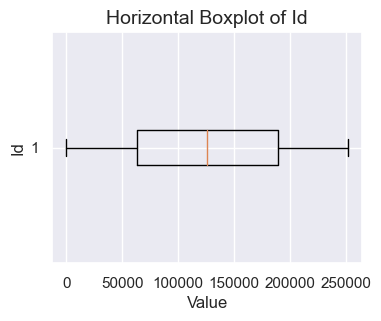

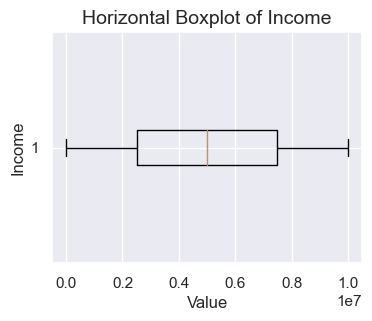

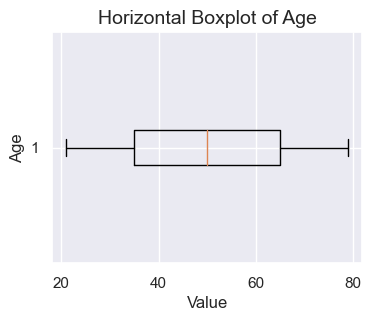

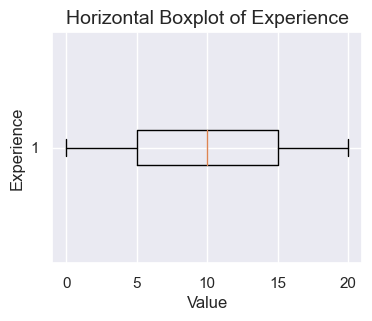

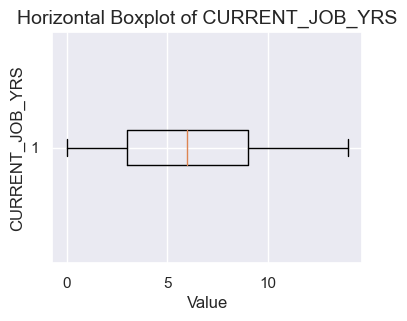

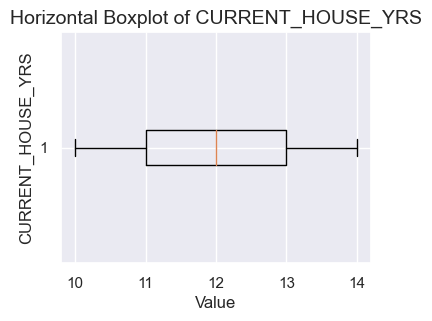

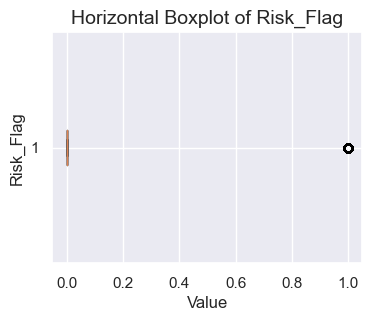

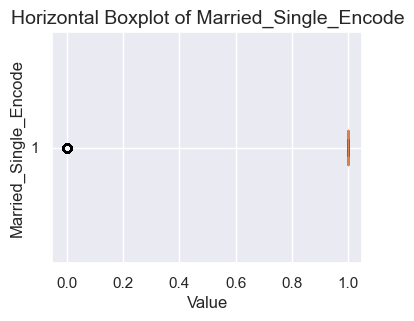

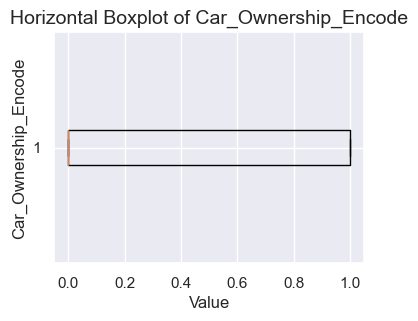

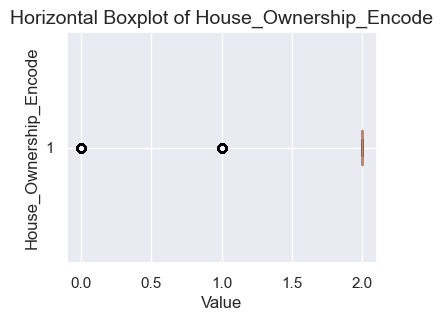

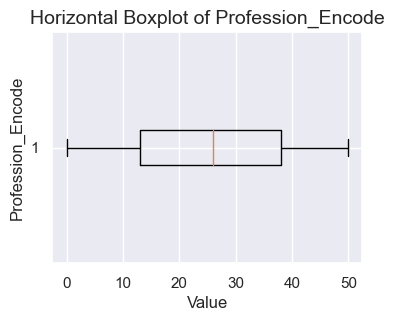

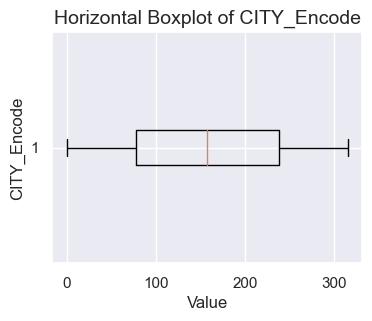

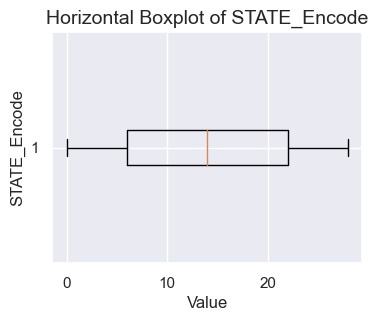

In [36]:
for col in num_cols.columns:
    plt.figure(figsize=(4, 3))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Horizontal Boxplot of {col}', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.show()

Tidak ada handle outlier dan akan menggunakan model yang robust terhadap outlier.

### D. Feature transformation

In [37]:
# Mengecek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      252000 non-null  int64 
 1   Income                  252000 non-null  int64 
 2   Age                     252000 non-null  int64 
 3   Experience              252000 non-null  int64 
 4   Married/Single          252000 non-null  object
 5   House_Ownership         252000 non-null  object
 6   Car_Ownership           252000 non-null  object
 7   Profession              252000 non-null  object
 8   CITY                    252000 non-null  object
 9   STATE                   252000 non-null  object
 10  CURRENT_JOB_YRS         252000 non-null  int64 
 11  CURRENT_HOUSE_YRS       252000 non-null  int64 
 12  Risk_Flag               252000 non-null  int64 
 13  Married_Single_Encode   252000 non-null  int32 
 14  Car_Ownership_Encode    252000 non-n

Tidak perlu feature transformation karena tipe data semua feature sudah sesuai.

### E. Feature encoding

In [41]:
label_encoder = pp.LabelEncoder()
df['Married_Single_Encode'] = label_encoder.fit_transform(df['Married/Single'])
df['Car_Ownership_Encode'] = label_encoder.fit_transform(df['Car_Ownership'])
df['House_Ownership_Encode'] = label_encoder.fit_transform(df['House_Ownership'])
df['Profession_Encode'] = label_encoder.fit_transform(df['Profession'])
df['CITY_Encode'] = label_encoder.fit_transform(df['CITY'])
df['STATE_Encode'] = label_encoder.fit_transform(df['STATE'])

Berdasarkan Chi-Square Test Categorical Columns memiliki pengaruh signifikan terhadap fitur target `Risk_Flag`.

### F. Handling class imbalance

In [42]:
df['Risk_Flag'].value_counts(normalize=True)

Risk_Flag
0    0.877
1    0.123
Name: proportion, dtype: float64

## <font color = 'green'> Feature Engineering </font>

In [49]:
# membuat kolom Age_Group
bins = [20, 35, 50, 65, 80]
labels = ['21-35', '36-50', '51-65', '66-79']

df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [50]:
# membuat kolom Age_Group
bins = [10310, 2503015, 5000694, 7477502, 9999938]
labels = ['Low', 'Medium', 'High', 'Very High']

df['Income_Category'] = pd.cut(df['Income'], bins=bins, labels=labels)

In [51]:
# membuat kolom profession_map 
def segment_profession(profession):
    if profession in ['Mechanical_engineer', 'Design_Engineer', 'Chemical_engineer', 'Biomedical_Engineer',
                      'Computer_hardware_engineer', 'Petroleum_Engineer', 'Civil_engineer',
                      'Industrial_Engineer', 'Technology_specialist', 'Surveyor']:
        return 'Engineering'
    elif profession in ['Software_Developer', 'Technical_writer', 'Graphic_Designer', 'Web_designer']:
        return 'IT/Software'
    elif profession in ['Civil_servant', 'Politician', 'Police_officer', 'Magistrate', 'Official', 'Army_officer']:
        return 'Government'
    elif profession in ['Librarian', 'Teacher']:
        return 'Education'
    elif profession in ['Economist', 'Financial_Analyst', 'Chartered_Accountant']:
        return 'Finance/Accounting'
    elif profession in ['Flight_attendant', 'Air_traffic_controller', 'Aviator']:
        return 'Aviation'
    elif profession in ['Architect', 'Designer', 'Fashion_Designer']:
        return 'Design'
    elif profession in ['Physician', 'Dentist', 'Surgeon','Psychologist']:
        return 'Medical Practitioner'
    elif profession in ['Hotel_Manager', 'Chef']:
        return 'Hospitality'
    elif profession in['Comedian', 'Artist']:
        return 'Art'
    elif profession in ['Secretary', 'Computer_operator']:
        return 'Administration'
    elif profession in ['Technician', 'Microbiologist', 'Geologist','Scientist', 'Geologist', 'Statistician','Analyst']:
        return 'Science/Research'
    else:
        return 'Other'

df['profession_map'] = df['Profession'].apply(segment_profession)

In [52]:
# membuat kolom Zone
def segment_state(state):
    if state in ['Rajasthan', 'Maharashtra', 'Gujarat']:
        return 'West Zone'
    elif state in ['Andhra_Pradesh','Kerala', 'Tamil_Nadu', 'Puducherry','Telangana','Karnataka']:
        return 'South Zone'
    elif state in ['Jammu_and_Kashmir','Himachal_Pradesh', 'Punjab','Chandigarh', 'Uttarakhand', 'Haryana','Delhi', 'Uttar_Pradesh','Uttar_Pradesh[5]']:
        return 'North Zone'
    elif state in ['Bihar','West_Bengal','Jharkhand', 'Odisha',]:
        return 'East Zone'
    elif state in ['Chhattisgarh','Madhya_Pradesh']:
        return 'Central Zone'
    elif state in ['Sikkim','Mizoram', 'Manipur','Tripura','Arunachal Pradesh','Assam']:
        return 'North East Zone'
    else:
        return 'Unknown'

df['Zone'] = df['STATE'].apply(segment_state)

In [53]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,...,Married_Single_Encode,Car_Ownership_Encode,House_Ownership_Encode,Profession_Encode,CITY_Encode,STATE_Encode,profession_map,Zone,Age_Group,Income_Category
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,...,1,0,2,33,251,13,Engineering,Central Zone,21-35,Low
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,...,1,0,2,43,227,14,IT/Software,West Zone,36-50,Very High
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,...,0,0,2,47,8,12,IT/Software,South Zone,66-79,Medium
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,...,1,1,2,43,54,17,IT/Software,East Zone,36-50,High
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,...,1,0,2,11,296,22,Government,South Zone,36-50,High


## <font color = 'green'> Descriptive Analysis </font>

In [8]:
numeric_cols = df.select_dtypes(include=['int64'])
categorical_cols = df.select_dtypes(include=['object'])

In [9]:
# Analisis Summary Kolom Numeric
numeric_cols.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Id,252000.0,1.260005e+05,7.274628e+04,1.0,63000.75,126000.5,189000.25,252000.0
Income,252000.0,4.997117e+06,2.878311e+06,10310.0,2503015.00,5000694.5,7477502.00,9999938.0
Age,252000.0,4.995407e+01,1.706385e+01,21.0,35.00,50.0,65.00,79.0
Experience,252000.0,1.008444e+01,6.002590e+00,0.0,5.00,10.0,15.00,20.0
CURRENT_JOB_YRS,252000.0,6.333877e+00,3.647053e+00,0.0,3.00,6.0,9.00,14.0
CURRENT_HOUSE_YRS,252000.0,1.199779e+01,1.399037e+00,10.0,11.00,12.0,13.00,14.0
Risk_Flag,252000.0,1.230000e-01,3.284379e-01,0.0,0.00,0.0,0.00,1.0


In [10]:
# Analisis Summary Kolom Categoric
categorical_cols.describe(include='all').transpose()

,count,unique,top,freq
Married/Single,252000,2,single,226272
House_Ownership,252000,3,rented,231898
Car_Ownership,252000,2,no,176000
Profession,252000,51,Physician,5957
CITY,252000,317,Vijayanagaram,1259
STATE,252000,29,Uttar_Pradesh,28400


Secara umum, tidak ada yang secara langsung aneh pada kolom kategorikal

## <font color = 'green'> Exploratory Data Analysis (EDA) </font>

### <font color = 'darkgreen'> 1. Univariate Analysis </font>

### Kolom Age

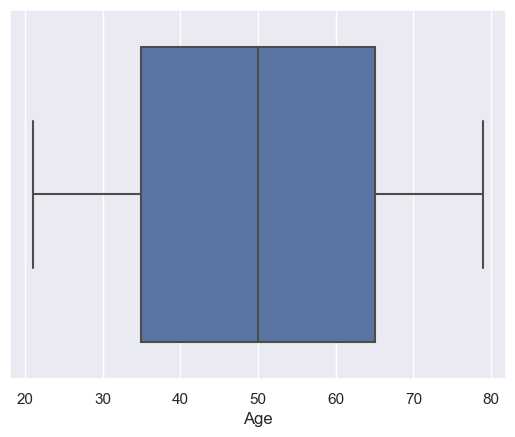

In [38]:
sns.boxplot(x='Age', data=df)
plt.show()

In [16]:
dfage = df[['Age']]
dfage['AgeGroup'] = dfage['Age'].apply(lambda x: '0-30' if x<=30 else '31-40' if x<=40 else '41-50' if x<=50 else '51-61' if x<= 60 else 'retire')

(3000.0, 84852.6)

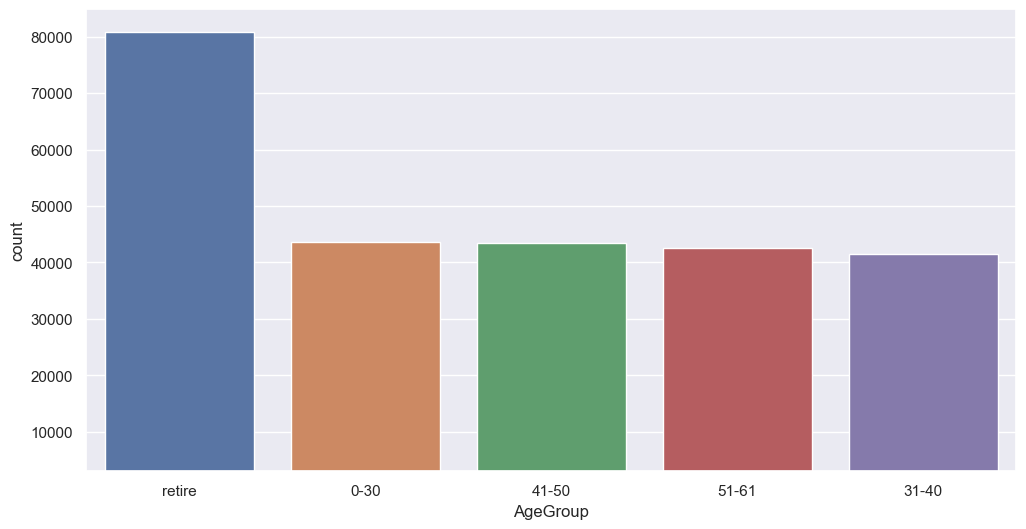

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x='AgeGroup', data=dfage, order = dfage['AgeGroup'].value_counts().index)
plt.xticks(rotation=0)
plt.ylim(3000)

### Kolom Income

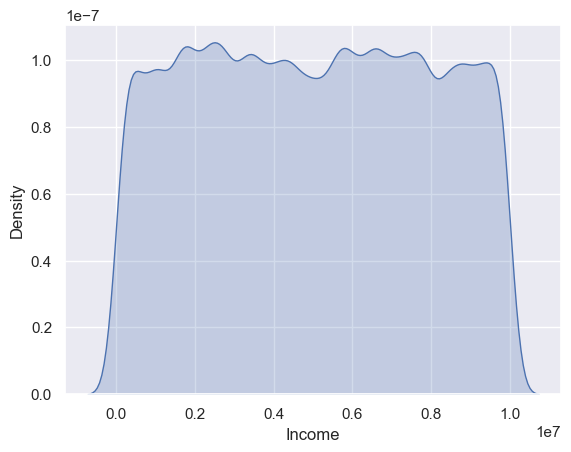

In [20]:
sns.kdeplot(df['Income'], shade=True)
plt.show()

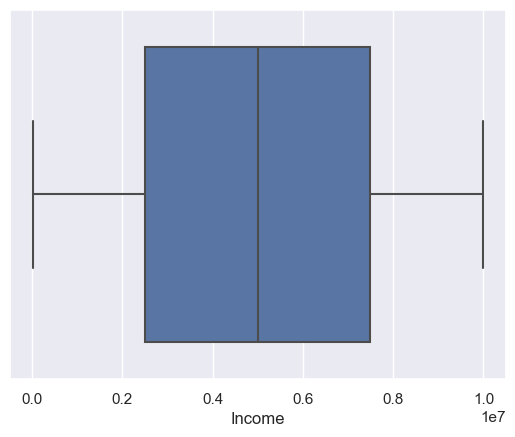

In [24]:
sns.boxplot(x='Income', data=df)
plt.show()

### Kolom Experience

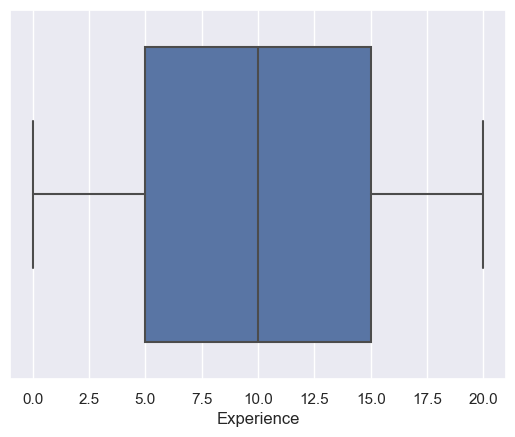

In [29]:
sns.boxplot(x='Experience', data=df)
plt.show()

In [25]:
dfexp = df[['Experience']]
dfexp['ExperienceGroup'] = dfexp['Experience'].apply(lambda x: 'New' if x<=5 else 'newIntermediate' if x<=10 else 'IntermediateAdvance' if x<=15 else 'Advance')

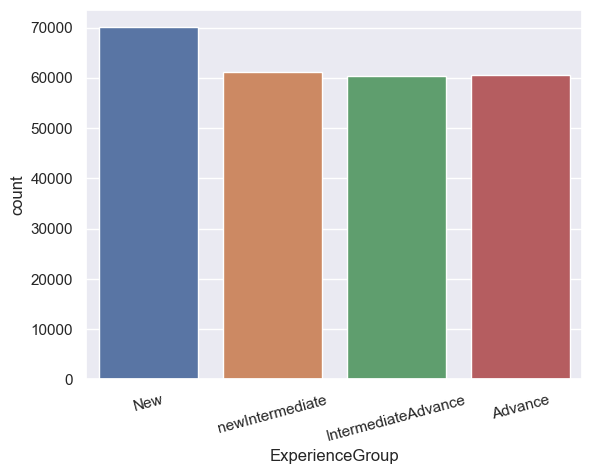

In [28]:
sns.countplot(x='ExperienceGroup', data=dfexp)
plt.xticks(rotation=15)
plt.show()

### Kolom Married/Single

In [32]:
df['Married/Single'].value_counts(normalize=True)

Married/Single
single     0.897905
married    0.102095
Name: proportion, dtype: float64

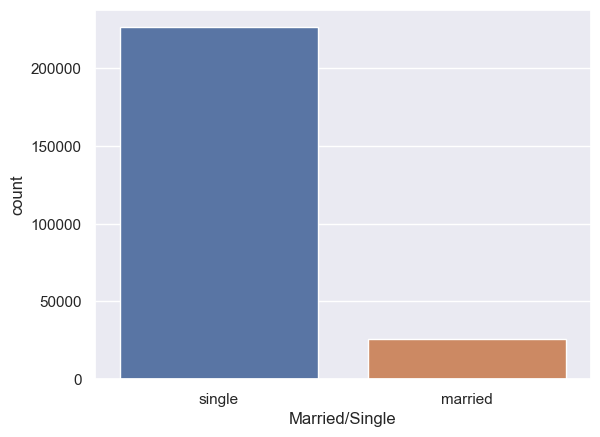

In [31]:
sns.countplot(x='Married/Single', data=df)
plt.show()

### Kolom House Ownership

In [33]:
df['House_Ownership'].value_counts(normalize=True)

House_Ownership
rented          0.920230
owned           0.051262
norent_noown    0.028508
Name: proportion, dtype: float64

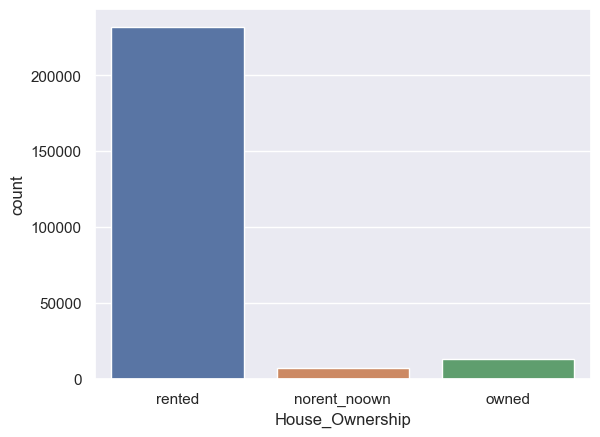

In [35]:
sns.countplot(x='House_Ownership', data=df)
plt.show()

### Kolom Car Ownership

In [36]:
df['Car_Ownership'].value_counts(normalize=True)

Car_Ownership
no     0.698413
yes    0.301587
Name: proportion, dtype: float64

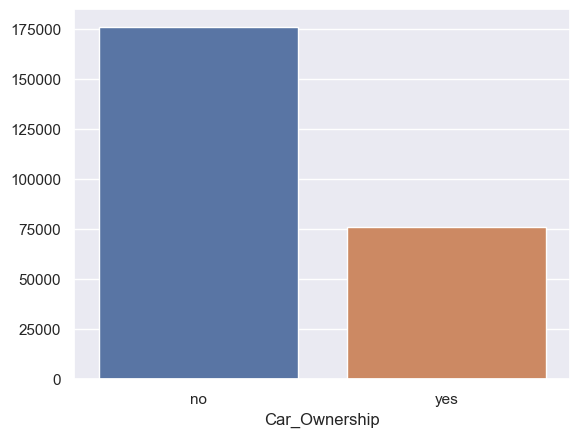

In [39]:
car_ownership_counts = df['Car_Ownership'].value_counts()

sns.barplot(x=car_ownership_counts.index, y=car_ownership_counts.values)
plt.show()

### Kolom City

In [42]:
df['CITY'].value_counts().sort_values(ascending=False).head()

CITY
Vijayanagaram    1259
Bhopal           1208
Bulandshahr      1185
Saharsa[29]      1180
Vijayawada       1172
Name: count, dtype: int64

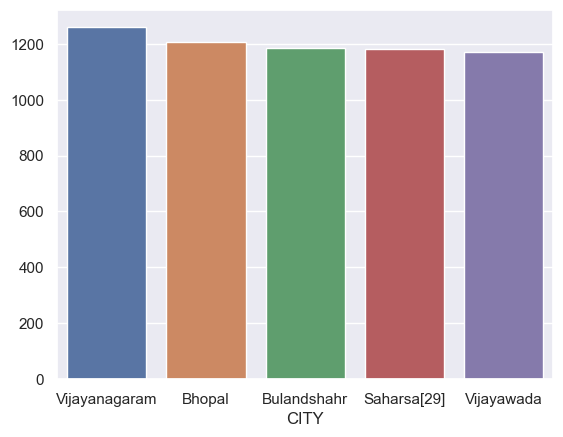

In [45]:
top_cities = df['CITY'].value_counts().sort_values(ascending=False).head()

sns.barplot(x=top_cities.index, y=top_cities.values)
plt.show()

### Kolom State

In [46]:
df['STATE'].value_counts().sort_values(ascending=False).head()

STATE
Uttar_Pradesh     28400
Maharashtra       25562
Andhra_Pradesh    25297
West_Bengal       23483
Bihar             19780
Name: count, dtype: int64

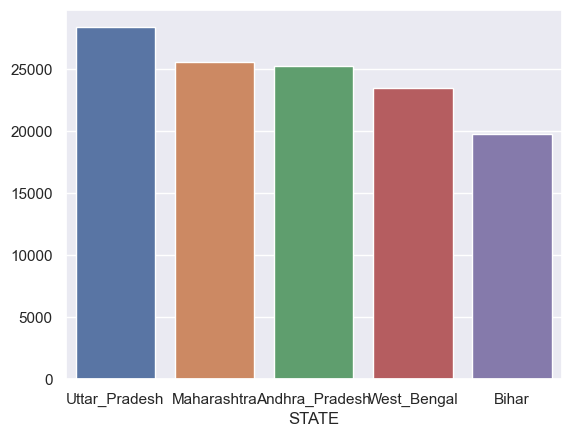

In [47]:
top_states = df['STATE'].value_counts().sort_values(ascending=False).head()

sns.barplot(x=top_states.index, y=top_states.values)
plt.show()

### Kolom Current Job Years

In [48]:
df['CURRENT_JOB_YRS'].value_counts().sort_values(ascending=False).head()

CURRENT_JOB_YRS
3    29460
4    28339
5    25091
6    23491
7    19925
Name: count, dtype: int64

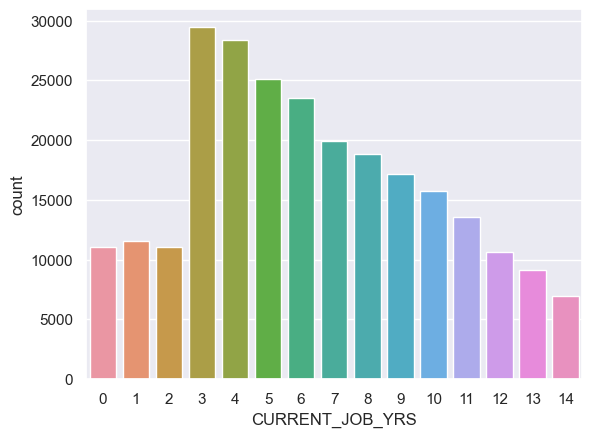

In [49]:
sns.countplot(x = 'CURRENT_JOB_YRS', data = df)
plt.show()

### Kolom Current House Years

In [52]:
df['CURRENT_HOUSE_YRS'].value_counts().sort_values(ascending=False)

CURRENT_HOUSE_YRS
11    51873
12    51791
13    50659
14    49003
10    48674
Name: count, dtype: int64

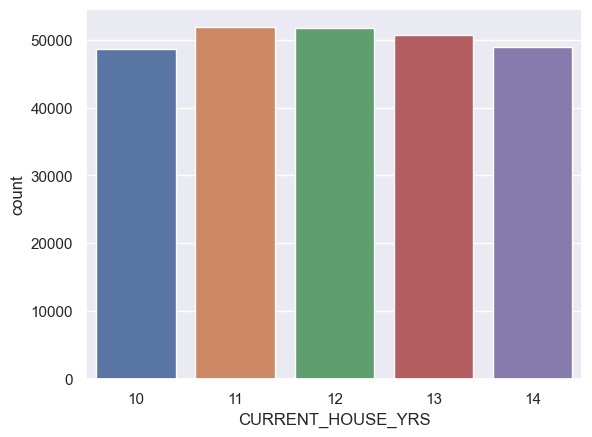

In [51]:
sns.countplot(x = 'CURRENT_HOUSE_YRS', data = df)
plt.show()

### Kolom Risk Flag

In [54]:
df['Risk_Flag'].value_counts()

Risk_Flag
0    221004
1     30996
Name: count, dtype: int64

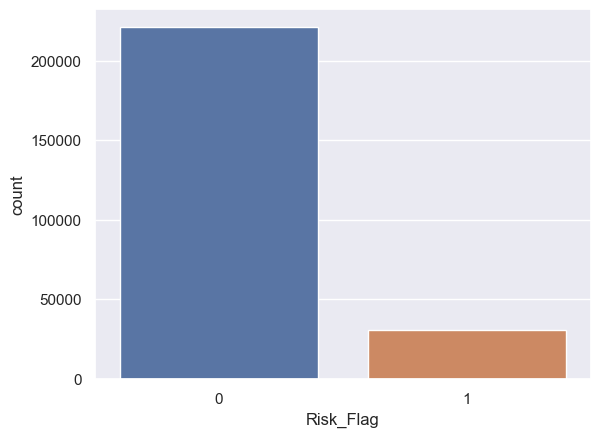

In [53]:
sns.countplot(x = 'Risk_Flag', data = df)
plt.show()

In [68]:
df['Risk_Flag'].value_counts(normalize=True)

Risk_Flag
0    0.877
1    0.123
Name: proportion, dtype: float64

### <font color = 'darkgreen'> 2. Multivariate Analysis </font>

### Numeric Columns

In [11]:
numeric_cols.corr()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,1.000000,-0.001324,-0.001816,-0.005810,-0.003250,0.001972,0.032153
Income,-0.001324,1.000000,-0.000652,0.006422,0.007045,-0.002397,-0.003091
Age,-0.001816,-0.000652,1.000000,-0.001118,0.002154,-0.020134,-0.021809
Experience,-0.005810,0.006422,-0.001118,1.000000,0.646098,0.019309,-0.034523
CURRENT_JOB_YRS,-0.003250,0.007045,0.002154,0.646098,1.000000,0.005372,-0.016942
CURRENT_HOUSE_YRS,0.001972,-0.002397,-0.020134,0.019309,0.005372,1.000000,-0.004375
Risk_Flag,0.032153,-0.003091,-0.021809,-0.034523,-0.016942,-0.004375,1.000000


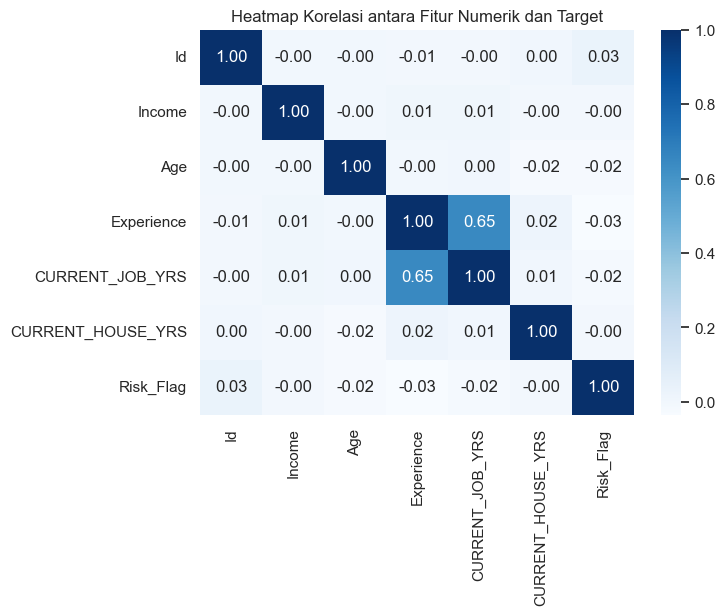

In [12]:
plt.figure(figsize=(7, 5))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Heatmap Korelasi antara Fitur Numerik dan Target', fontsize=12)
plt.show()

Dari hasil ini, tidak ada fitur numerik yang memiliki korelasi yang signifikan dengan target `Risk_Flag`.

In [13]:
categorical_cols.columns

Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE'],
      dtype='object')

In [14]:
label_encoder = pp.LabelEncoder()
df['Married_Single_Encode'] = label_encoder.fit_transform(df['Married/Single'])
df['Car_Ownership_Encode'] = label_encoder.fit_transform(df['Car_Ownership'])
df['House_Ownership_Encode'] = label_encoder.fit_transform(df['House_Ownership'])
df['Profession_Encode'] = label_encoder.fit_transform(df['Profession'])
df['CITY_Encode'] = label_encoder.fit_transform(df['CITY'])
df['STATE_Encode'] = label_encoder.fit_transform(df['STATE'])

df.sample(5)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Married_Single_Encode,Car_Ownership_Encode,House_Ownership_Encode,Profession_Encode,CITY_Encode,STATE_Encode
62915,62916,4141656,27,20,single,rented,no,Microbiologist,Hazaribagh,Jharkhand,12,14,1,1,0,2,34,117,10
140630,140631,2101952,46,18,single,rented,yes,Technical_writer,Berhampore,West_Bengal,7,14,0,1,1,2,47,39,28
151849,151850,9506949,49,14,single,rented,yes,Civil_servant,Bellary,Karnataka,13,11,0,1,1,2,11,38,11
222772,222773,1270423,27,3,single,rented,yes,Industrial_Engineer,Meerut,Uttar_Pradesh,3,10,0,1,1,2,29,188,25
125633,125634,4542920,64,11,single,owned,yes,Physician,Mysore[7][8][9],Karnataka,11,14,0,1,1,1,37,201,11


In [15]:
df_numeric = df.select_dtypes(include=['int'])
df_numeric.corr()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Married_Single_Encode,Car_Ownership_Encode,House_Ownership_Encode,Profession_Encode,CITY_Encode,STATE_Encode
Id,1.000000,-0.001324,-0.001816,-0.005810,-0.003250,0.001972,0.032153,0.001134,-0.004313,-0.002583,-0.005734,-0.000972,0.002012
Income,-0.001324,1.000000,-0.000652,0.006422,0.007045,-0.002397,-0.003091,0.002682,0.004068,0.016433,0.000725,-0.001919,-0.004067
Age,-0.001816,-0.000652,1.000000,-0.001118,0.002154,-0.020134,-0.021809,-0.005323,0.009395,-0.009820,-0.008551,0.002104,-0.004985
Experience,-0.005810,0.006422,-0.001118,1.000000,0.646098,0.019309,-0.034523,-0.001752,0.007519,-0.007912,0.000975,-0.025703,-0.001251
CURRENT_JOB_YRS,-0.003250,0.007045,0.002154,0.646098,1.000000,0.005372,-0.016942,0.004251,0.011099,-0.009790,-0.004536,-0.027353,0.008745
CURRENT_HOUSE_YRS,0.001972,-0.002397,-0.020134,0.019309,0.005372,1.000000,-0.004375,-0.007539,0.000251,-0.005618,0.001954,-0.010654,0.007281
Risk_Flag,0.032153,-0.003091,-0.021809,-0.034523,-0.016942,-0.004375,1.000000,0.021092,-0.024036,0.023622,-0.004900,0.004575,-0.003401
Married_Single_Encode,0.001134,0.002682,-0.005323,-0.001752,0.004251,-0.007539,0.021092,1.000000,0.001206,-0.022501,-0.007534,0.012280,-0.009477
Car_Ownership_Encode,-0.004313,0.004068,0.009395,0.007519,0.011099,0.000251,-0.024036,0.001206,1.000000,-0.001233,0.011887,0.001648,0.026000
House_Ownership_Encode,-0.002583,0.016433,-0.009820,-0.007912,-0.009790,-0.005618,0.023622,-0.022501,-0.001233,1.000000,0.001242,-0.014447,-0.007792


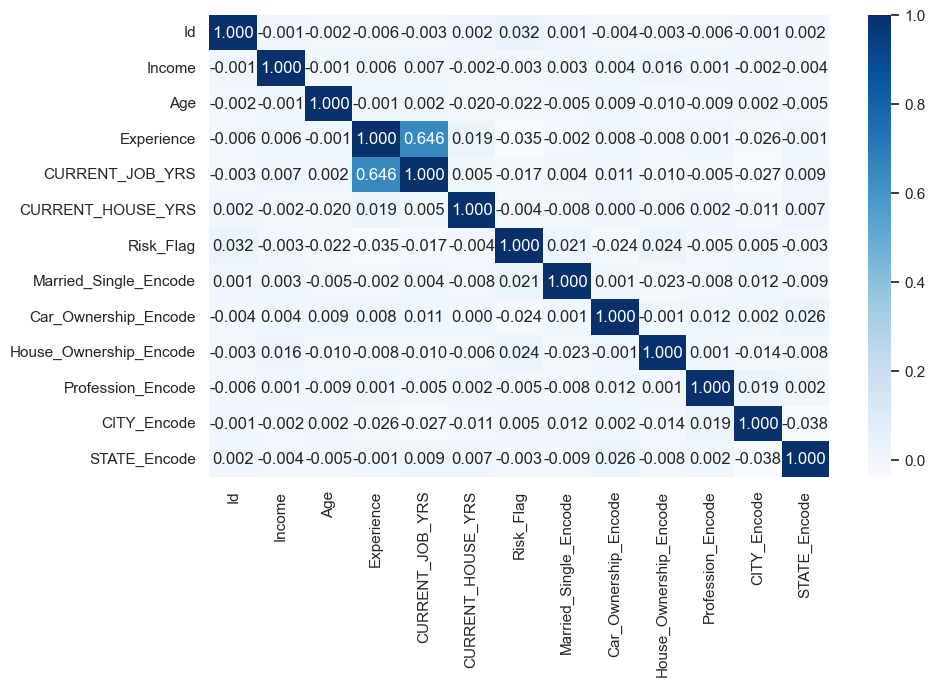

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='Blues', fmt='.3f')
plt.show()

### Categorical Columns

### Kolom 'Married/Single' VS 'Risk_Flag'

In [91]:
status_grouped = df.groupby(['Married/Single', 'Risk_Flag']).size().unstack()
status_grouped['pcg'] = (status_grouped[1] / status_grouped.sum(axis=1)) * 100
status_grouped.sort_values(by='pcg', ascending=False)

Risk_Flag,0,1,pcg
Married/Single,,,
single,197912,28360,12.533588
married,23092,2636,10.245647


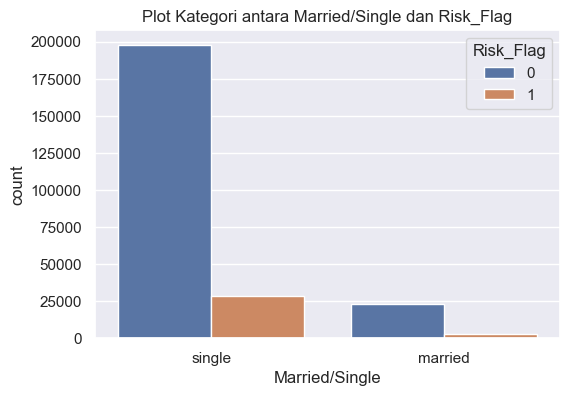

In [92]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Married/Single', hue='Risk_Flag', data=df)
plt.title('Plot Kategori antara Married/Single dan Risk_Flag', fontsize=12)
plt.xticks(rotation=0)
plt.show()

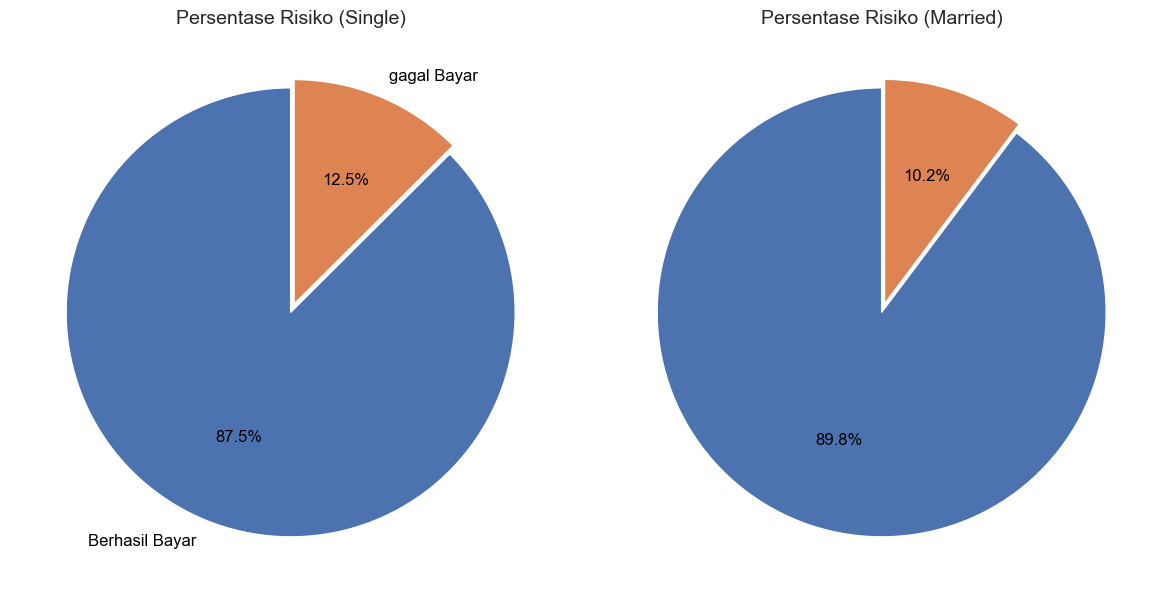

In [93]:
single_data = status_grouped.loc['single']
single_labels = ['Berhasil Bayar', 'gagal Bayar']
single_sizes = [single_data[0], single_data[1]]

married_data = status_grouped.loc['married']
married_labels = ['Berhasil Bayar', 'Gagal Bayar']
married_sizes = [married_data[0], married_data[1]]

pie_explode = (0, 0.04) 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].pie(single_sizes, labels=single_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[0].set_title('Persentase Risiko (Single)', fontsize=14)

axes[1].pie(married_sizes, labels=married_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, labeldistance=None, explode=pie_explode)
axes[1].set_title('Persentase Risiko (Married)', fontsize=14)

plt.tight_layout()
plt.show()

### Kolom 'House_Ownership' VS 'Risk_Flag'

In [94]:
house_grouped = df.groupby(['House_Ownership', 'Risk_Flag']).size().unstack()
house_grouped['pcg'] = (house_grouped[1] / house_grouped.sum(axis=1)) * 100
house_grouped.sort_values(by='pcg', ascending=False)

Risk_Flag,0,1,pcg
House_Ownership,,,
rented,202777,29121,12.557676
norent_noown,6469,715,9.952673
owned,11758,1160,8.979718


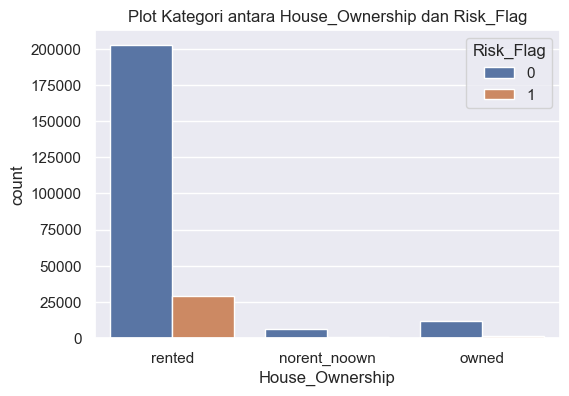

In [95]:
# Plot untuk kolom 'House_Ownership'
plt.figure(figsize=(6, 4))
sns.countplot(x='House_Ownership', hue='Risk_Flag', data=df)
plt.title('Plot Kategori antara House_Ownership dan Risk_Flag', fontsize=12)
plt.xticks(rotation=0)
plt.show()

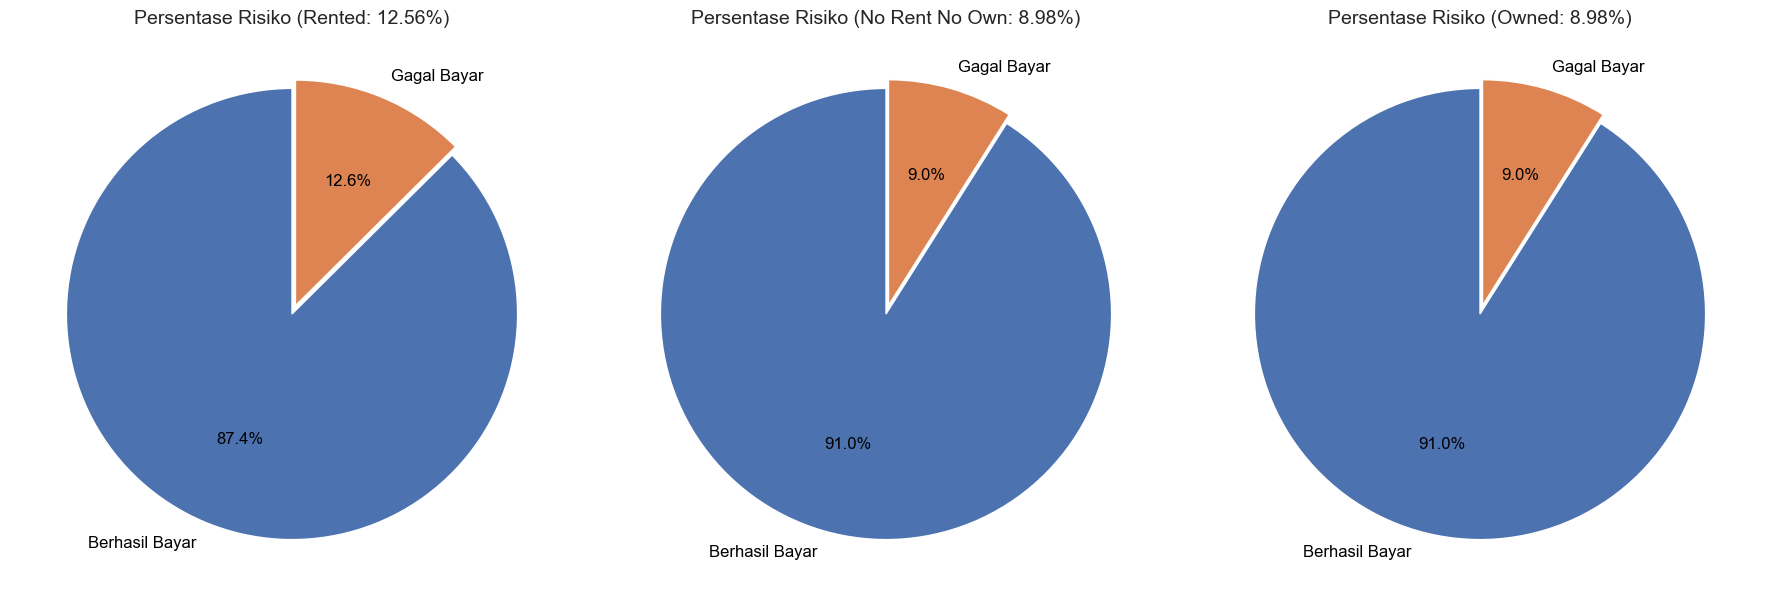

In [96]:
rented_data = house_grouped.loc['rented']
rented_labels = ['Berhasil Bayar', 'Gagal Bayar']
rented_sizes = [rented_data[0], rented_data[1]]
rented_pcg = rented_data['pcg']

owned_data = house_grouped.loc['norent_noown']
owned_labels = ['Berhasil Bayar', 'Gagal Bayar']
owned_sizes = [owned_data[0], owned_data[1]]
owned_pcg = owned_data['pcg']

owned_data = house_grouped.loc['owned']
owned_labels = ['Berhasil Bayar', 'Gagal Bayar']
owned_sizes = [owned_data[0], owned_data[1]]
owned_pcg = owned_data['pcg']

pie_explode = (0, 0.04)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].pie(rented_sizes, labels=rented_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[0].set_title(f'Persentase Risiko (Rented: {rented_pcg:.2f}%)', fontsize=14)

axes[1].pie(owned_sizes, labels=owned_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[1].set_title(f'Persentase Risiko (No Rent No Own: {owned_pcg:.2f}%)', fontsize=14)

axes[2].pie(owned_sizes, labels=owned_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[2].set_title(f'Persentase Risiko (Owned: {owned_pcg:.2f}%)', fontsize=14)

plt.tight_layout()
plt.show()

### Kolom 'Profession' VS 'Risk_Flag'

#### Profession By Grouped

In [26]:
def segment_profession(profession):
    if profession in ['Mechanical_engineer', 'Design_Engineer', 'Chemical_engineer', 'Biomedical_Engineer',
                      'Computer_hardware_engineer', 'Petroleum_Engineer', 'Civil_engineer',
                      'Industrial_Engineer', 'Technology_specialist', 'Surveyor']:
        return 'Engineering'
    elif profession in ['Software_Developer', 'Technical_writer', 'Graphic_Designer', 'Web_designer']:
        return 'IT/Software'
    elif profession in ['Civil_servant', 'Politician', 'Police_officer', 'Magistrate', 'Official', 'Army_officer']:
        return 'Government'
    elif profession in ['Librarian', 'Teacher']:
        return 'Education'
    elif profession in ['Economist', 'Financial_Analyst', 'Chartered_Accountant']:
        return 'Finance/Accounting'
    elif profession in ['Flight_attendant', 'Air_traffic_controller', 'Aviator']:
        return 'Aviation'
    elif profession in ['Architect', 'Designer', 'Fashion_Designer']:
        return 'Design'
    elif profession in ['Physician', 'Dentist', 'Surgeon','Psychologist']:
        return 'Medical Practitioner'
    elif profession in ['Hotel_Manager', 'Chef']:
        return 'Hospitality'
    elif profession in['Comedian', 'Artist']:
        return 'Art'
    elif profession in ['Secretary', 'Computer_operator']:
        return 'Administration'
    elif profession in ['Technician', 'Microbiologist', 'Geologist','Scientist', 'Geologist', 'Statistician','Analyst']:
        return 'Science/Research'
    else:
        return 'Other'

df['profession_map'] = df['Profession'].apply(segment_profession)

In [98]:
profession_map_grouped = df.groupby(['profession_map', 'Risk_Flag']).size().unstack()
profession_map_grouped['pcg'] = (profession_map_grouped[1] / profession_map_grouped.sum(axis=1)) * 100
profession_map_grouped = profession_map_grouped.sort_values(by='pcg', ascending=False).head(10)
profession_map_grouped

Risk_Flag,0,1,pcg
profession_map,,,
Government,24698,3799,13.331228
Aviation,13176,1991,13.127184
Science/Research,25839,3833,12.917902
Hospitality,8549,1264,12.880872
Administration,8772,1279,12.725102
IT/Software,18179,2632,12.647158
Other,20619,2921,12.408666
Art,8895,1225,12.104743
Design,12834,1725,11.848341


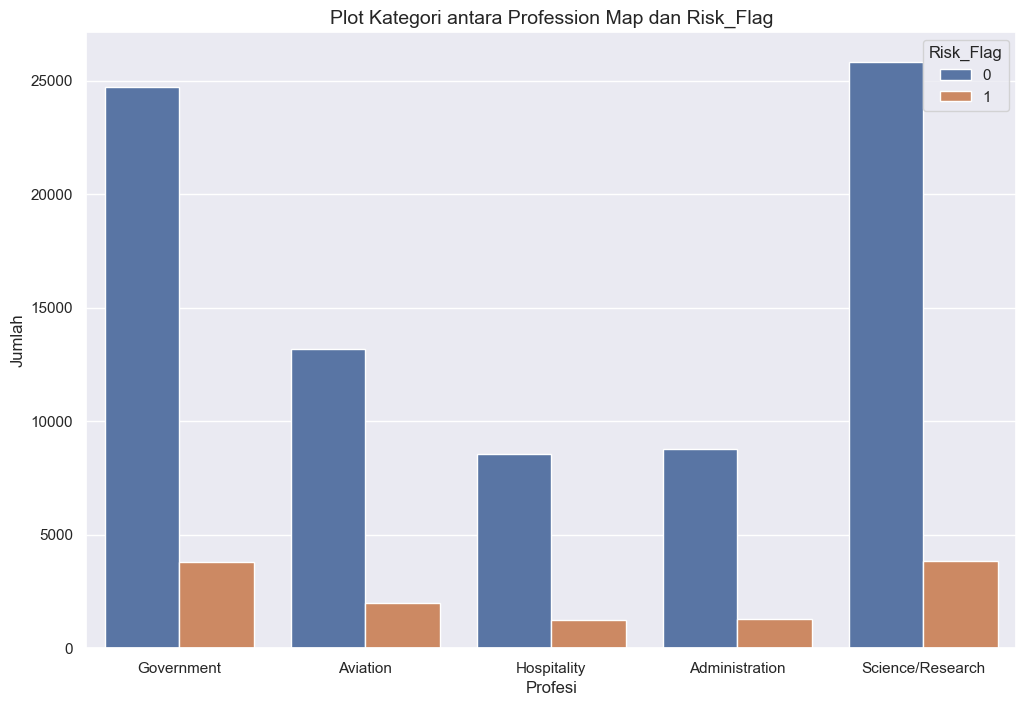

In [99]:
top_profession_maps = profession_map_grouped.sort_values(by='pcg', ascending=False).head(5)

plt.figure(figsize=(12, 8))
sns.countplot(x='profession_map', hue='Risk_Flag', data=df[df['profession_map'].isin(top_profession_maps.index)])
plt.title('Plot Kategori antara Profession Map dan Risk_Flag', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Profesi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

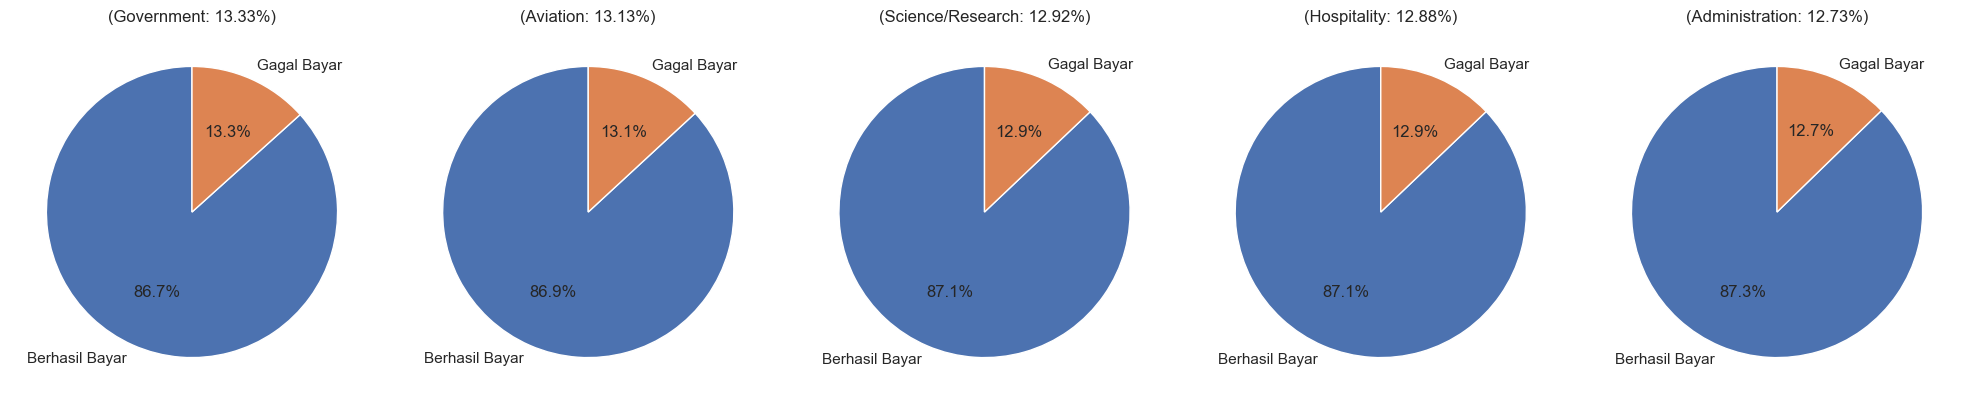

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, profession in enumerate(top_profession_maps.index):
    axes[i].pie(top_profession_maps.loc[profession, [0, 1]], labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'({profession}: {top_profession_maps["pcg"][profession]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

#### Profession By Specific

In [112]:
profession_grouped = df.groupby(['Profession', 'Risk_Flag']).size().unstack()
profession_grouped['pcg'] = (profession_grouped[1] / profession_grouped.sum(axis=1)) * 100
profession_grouped.sort_values(by='pcg', ascending=False).head()

Risk_Flag,0,1,pcg
Profession,,,
Police_officer,4209,826,16.405164
Chartered_Accountant,3803,690,15.357222
Army_officer,3952,709,15.211328
Surveyor,4000,714,15.146373
Software_Developer,4303,750,14.842668


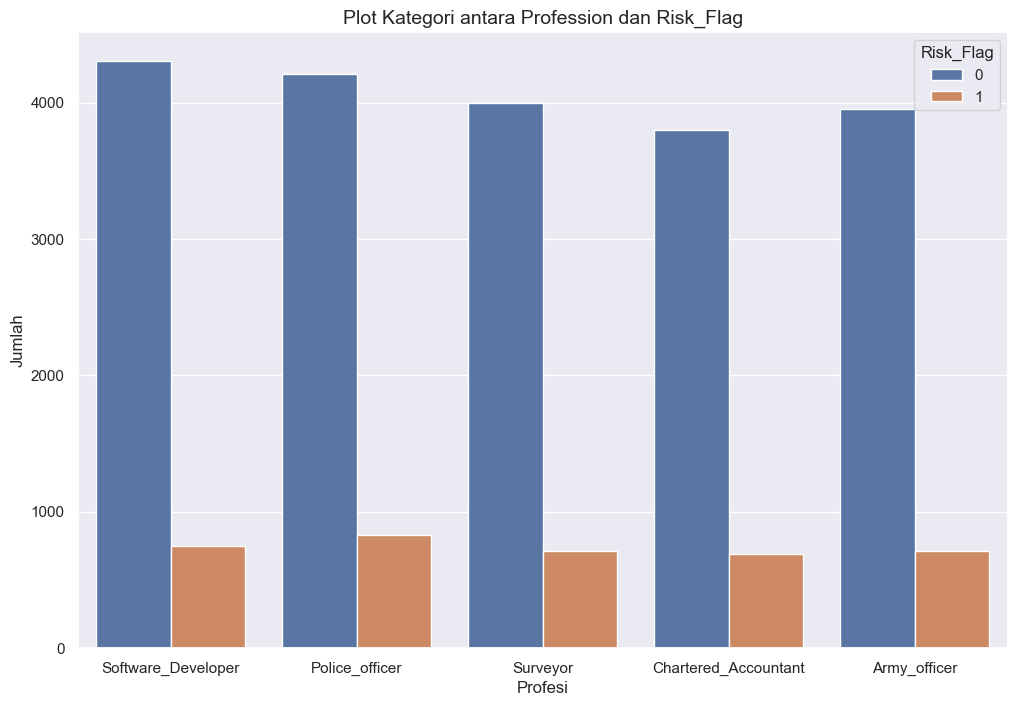

In [109]:
top_professions = profession_grouped.sort_values(by='pcg', ascending=False).head(5)

plt.figure(figsize=(12, 8))
sns.countplot(x='Profession', hue='Risk_Flag', data=df[df['Profession'].isin(top_professions.index)])
plt.title('Plot Kategori antara Profession dan Risk_Flag', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Profesi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

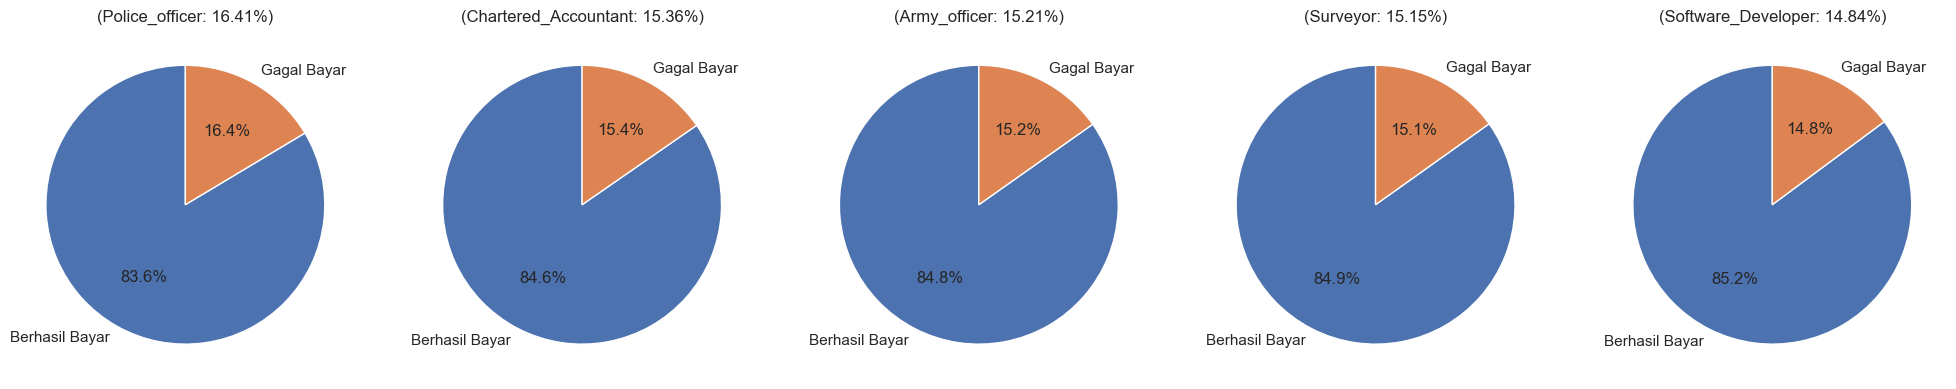

In [110]:
top_professions = profession_grouped.sort_values(by='pcg', ascending=False).head(5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, profession in enumerate(top_professions.index):
    axes[i].pie(top_professions.loc[profession, [0, 1]], labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'({profession}: {top_professions["pcg"][profession]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

### Kolom 'CITY' VS 'Risk_Flag'

In [131]:
city_grouped = df.groupby(['CITY', 'Risk_Flag']).size().unstack()
city_grouped['pcg'] = (city_grouped[1] / city_grouped.sum(axis=1)) * 100
city_grouped.sort_values(by='pcg', ascending=False).head()

Risk_Flag,0,1,pcg
CITY,,,
Bhubaneswar,409,198,32.619440
Gwalior,448,168,27.272727
Bettiah[33],335,122,26.695842
Kochi,718,243,25.286160
Raiganj,546,172,23.955432


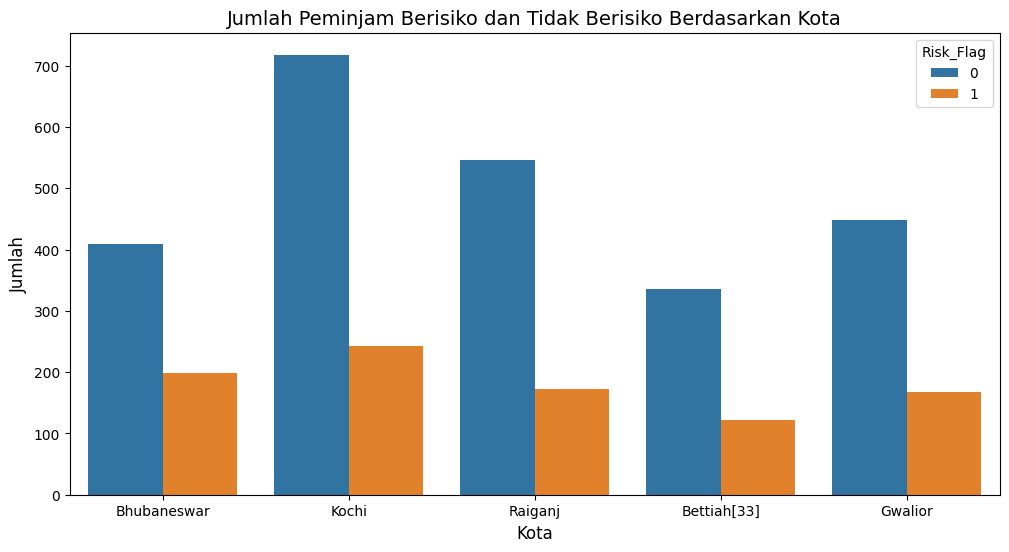

In [138]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['CITY'].isin(top_cities.index)], x='CITY', hue='Risk_Flag')
plt.title('Jumlah Peminjam Berisiko dan Tidak Berisiko Berdasarkan Kota', fontsize=14)
plt.xlabel('Kota', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

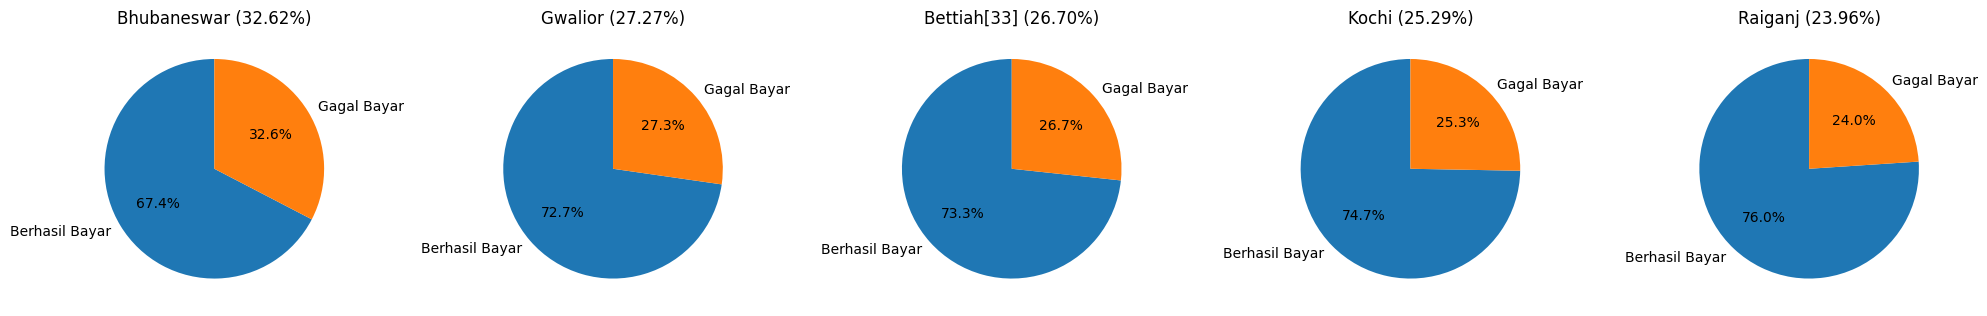

In [139]:
# Membuat subplot untuk pie chart
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# Membuat pie chart untuk setiap kota teratas
for i, city in enumerate(top_cities.index):
    sizes = top_cities.loc[city, [0, 1]]
    axes[i].pie(sizes, labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{city} ({top_cities["pcg"][city]:.2f}%)', fontsize=12)

# Menampilkan plot pie chart
plt.tight_layout()
plt.show()

### Kolom 'State' VS 'Risk_Flag'

#### State By Grouped

In [27]:
def segment_state(state):
    if state in ['Rajasthan', 'Maharashtra', 'Gujarat']:
        return 'West Zone'
    elif state in ['Andhra_Pradesh','Kerala', 'Tamil_Nadu', 'Puducherry','Telangana','Karnataka']:
        return 'South Zone'
    elif state in ['Jammu_and_Kashmir','Himachal_Pradesh', 'Punjab','Chandigarh', 'Uttarakhand', 'Haryana','Delhi', 'Uttar_Pradesh','Uttar_Pradesh[5]']:
        return 'North Zone'
    elif state in ['Bihar','West_Bengal','Jharkhand', 'Odisha',]:
        return 'East Zone'
    elif state in ['Chhattisgarh','Madhya_Pradesh']:
        return 'Central Zone'
    elif state in ['Sikkim','Mizoram', 'Manipur','Tripura','Arunachal Pradesh','Assam']:
        return 'North East Zone'
    else:
        return 'Unknown'

df['Zone'] = df['STATE'].apply(segment_state)

In [121]:
zone_grouped = df.groupby(['Zone', 'Risk_Flag']).size().unstack().sort_values(by=1, ascending=False)
zone_grouped['pcg'] = (zone_grouped[1] / zone_grouped.sum(axis=1)) * 100
zone_grouped.sort_values(by='pcg', ascending=False).head()

Risk_Flag,0,1,pcg
Zone,,,
Central Zone,15265,2691,14.986634
North East Zone,8806,1371,13.471554
East Zone,49435,7451,13.098126
West Zone,40614,5530,11.984223
South Zone,60505,7946,11.608304


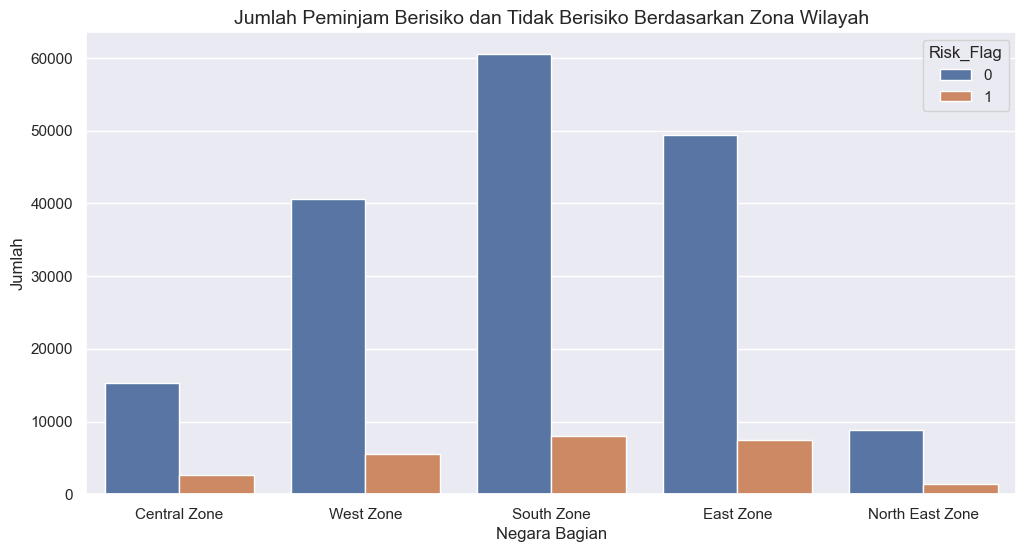

In [124]:
top_zone = zone_grouped.sort_values(by='pcg', ascending=False).head()

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['Zone'].isin(top_zone.index)], x='Zone', hue='Risk_Flag')
plt.title('Jumlah Peminjam Berisiko dan Tidak Berisiko Berdasarkan Zona Wilayah', fontsize=14)
plt.xlabel('Negara Bagian', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

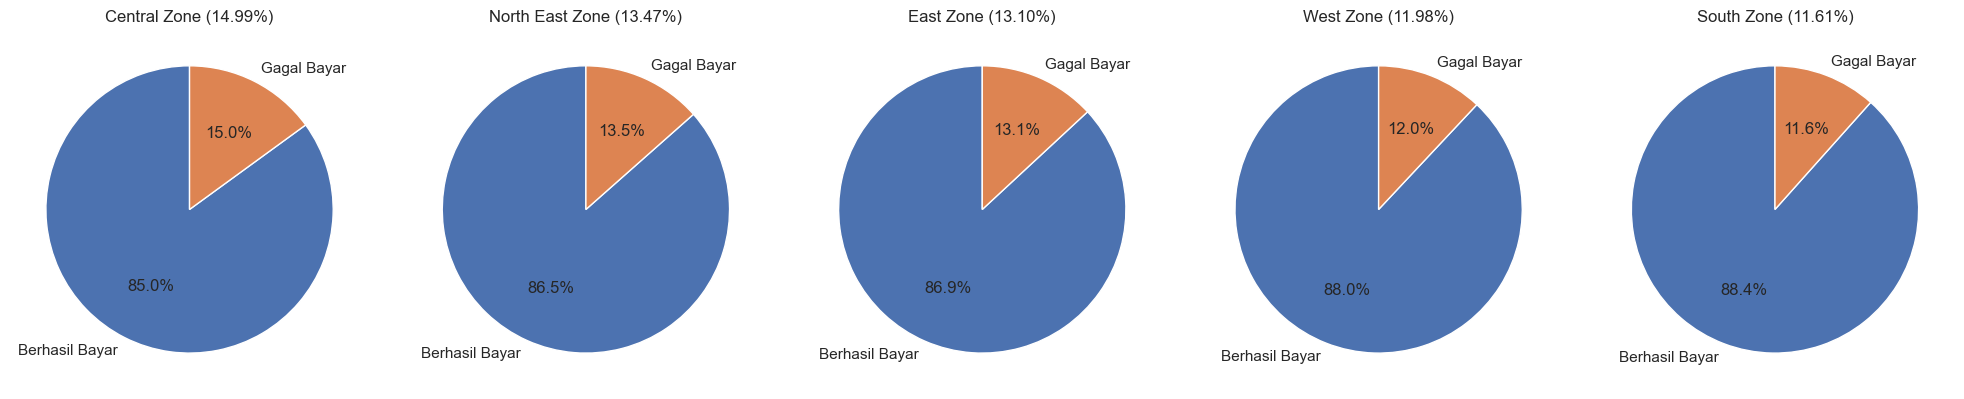

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, zone in enumerate(top_zone.index):
    sizes = top_zone.loc[zone, [0, 1]]
    axes[i].pie(sizes, labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{zone} ({top_zone["pcg"][zone]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

#### State By Specific

In [140]:
state_grouped = df.groupby(['STATE', 'Risk_Flag']).size().unstack().sort_values(by=1, ascending=False)
state_grouped['pcg'] = (state_grouped[1] / state_grouped.sum(axis=1)) * 100
state_grouped.sort_values(by='pcg', ascending=False).head()

Risk_Flag,0,1,pcg
STATE,,,
Manipur,666,183,21.554770
Tripura,673,136,16.810878
Kerala,4835,970,16.709733
Jammu_and_Kashmir,1497,283,15.898876
Madhya_Pradesh,11942,2180,15.436907


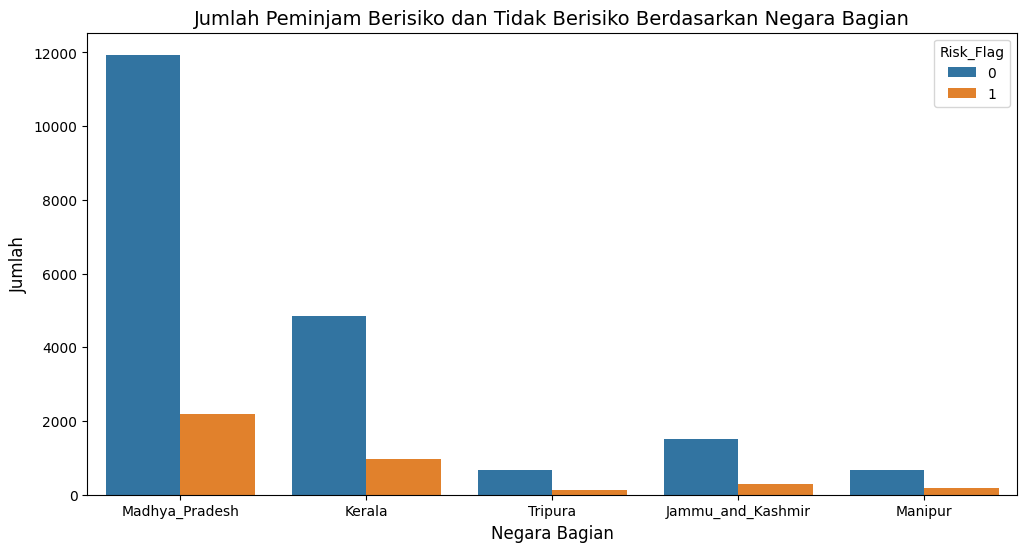

In [143]:
top_states = state_grouped.sort_values(by='pcg', ascending=False).head()

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['STATE'].isin(top_states.index)], x='STATE', hue='Risk_Flag')
plt.title('Jumlah Peminjam Berisiko dan Tidak Berisiko Berdasarkan Negara Bagian', fontsize=14)
plt.xlabel('Negara Bagian', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

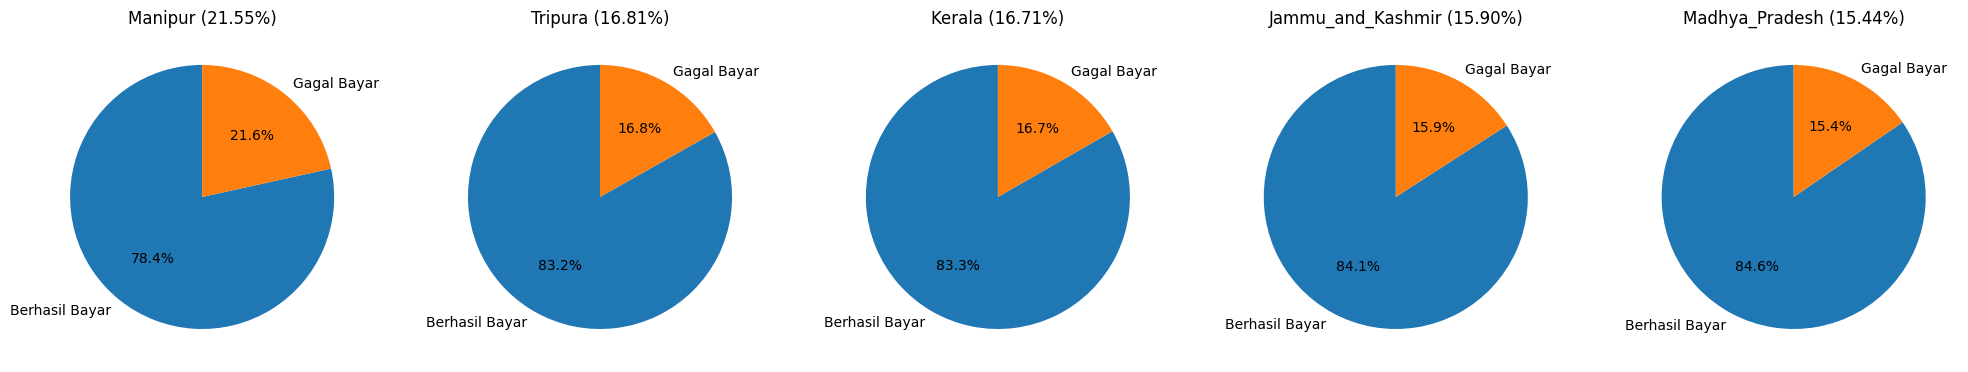

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, state in enumerate(top_states.index):
    sizes = top_states.loc[state, [0, 1]]
    axes[i].pie(sizes, labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{state} ({top_states["pcg"][state]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

### Uji ANOVA Test

In [25]:
df.columns

Index(['Id', 'Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag',
       'Married_Single_Encode', 'Car_Ownership_Encode',
       'House_Ownership_Encode', 'Profession_Encode', 'CITY_Encode',
       'STATE_Encode'],
      dtype='object')

In [24]:
for col in numeric_cols:
    if col != 'Id' and col != 'Risk_Flag':
        print(f"Uji ANOVA untuk {col}:")
        groups = [df[col][df['Risk_Flag'] == i] for i in df['Risk_Flag'].unique()]
        f_stat, p_value = f_oneway(*groups)
        print("Nilai F-statistic:", f_stat)
        print("P-value:", p_value)
        if p_value < 0.05:
            print("Terdapat perbedaan yang signifikan.")
        else:
            print("Tidak terdapat perbedaan yang signifikan.")
        print()

Uji ANOVA untuk Income:
Nilai F-statistic: 2.4079446287996715
P-value: 0.1207220319583281
Tidak terdapat perbedaan yang signifikan.

Uji ANOVA untuk Age:
Nilai F-statistic: 119.91850679948466
P-value: 6.687623647499306e-28
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk Experience:
Nilai F-statistic: 300.69230651920316
P-value: 2.5475634865752383e-67
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk CURRENT_JOB_YRS:
Nilai F-statistic: 72.34852624927743
P-value: 1.813221223267855e-17
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk CURRENT_HOUSE_YRS:
Nilai F-statistic: 4.823851147277152
P-value: 0.02806947277438121
Terdapat perbedaan yang signifikan.



### Uji Chi-Square Test

In [20]:
for col in categorical_cols:
    print(f"Uji chi-square untuk {col}:")
    contingency_table = pd.crosstab(df[col], df['Risk_Flag'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print("Nilai chi-square statistic:", chi2_stat)
    print("P-value:", p_value)
    if p_value < 0.05:
        print("Terdapat hubungan yang signifikan antara", col, "dan Risk_Flag.")
    else:
        print("Tidak terdapat hubungan yang signifikan antara", col, "dan Risk_Flag.")
    print()

Uji chi-square untuk Married/Single:
Nilai chi-square statistic: 111.89204667099783
P-value: 3.773053705715196e-26
Terdapat hubungan yang signifikan antara Married/Single dan Risk_Flag.

Uji chi-square untuk House_Ownership:
Nilai chi-square statistic: 182.98924138871385
P-value: 1.8381930028370595e-40
Terdapat hubungan yang signifikan antara House_Ownership dan Risk_Flag.

Uji chi-square untuk Car_Ownership:
Nilai chi-square statistic: 145.42374419378916
P-value: 1.7350853850183742e-33
Terdapat hubungan yang signifikan antara Car_Ownership dan Risk_Flag.

Uji chi-square untuk Profession:
Nilai chi-square statistic: 613.4862093528226
P-value: 5.108641602000937e-98
Terdapat hubungan yang signifikan antara Profession dan Risk_Flag.

Uji chi-square untuk CITY:
Nilai chi-square statistic: 5223.113291690215
P-value: 0.0
Terdapat hubungan yang signifikan antara CITY dan Risk_Flag.

Uji chi-square untuk STATE:
Nilai chi-square statistic: 733.396800420077
P-value: 2.0057472384130266e-136
Terda